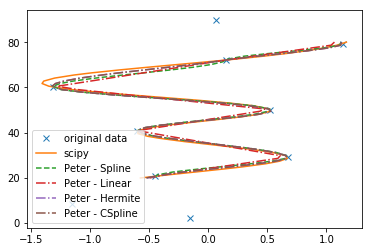

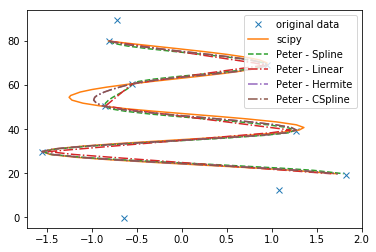

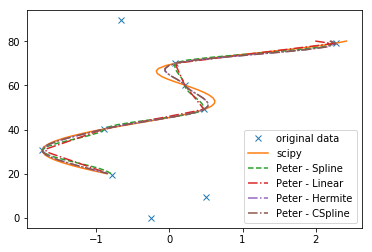

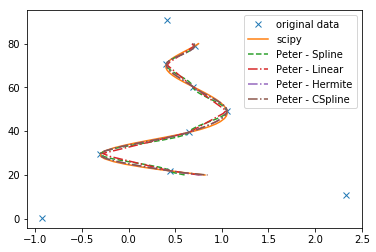

In [8]:
import numpy as np
import warnings

def along_axis(y, x, newx, axis, inverse=False, method='linear', gradient='numpy', c=None):
    """ Interpolate vertical profiles, e.g. of atmospheric variables
    using vectorized numpy operations

    - This function assumes that the x-xoordinate increases monotonically

    args
    ----
    y : nd-array
        The variable to be interpolated
    x : nd-array or 1d-array
        The coordinate associated with y, along which to interpolate.
        If nd-array, this variable should have the same shape as y
        If 1d, len(x) should be equal to the length of y along `axis`
    newx : nd-array or 1d-array or float
           The new coordinates to which y should be interpolated.
           If nd-array, this variable should have the same shape as y
           If 1d, len(x) should be equal to the length of y along `axis`
    method : string
             'linear', straightforward linear interpolation
             'cubic', Algorithm from: http://www.paulinternet.nl/?page=bicubic
                    f(x) = ax**3+bx**2+cx+d with
                    a = 2f(0) - 2f(1) + f'(0) + f'(1)
                    b = -3f(0) + 3f(1) - 2f'(0) - f'(1)
                    c = f'(0)
                    d = f(0)

             'hermite', Algorithm from https://en.wikipedia.org/wiki/Cubic_Hermite_spline
                    f(x) = h00(x)*f(0)+h10(x)*f'(0)+h01(x)*f(1)+h11(x)*f'(1) with
                    h00(x) = 2x**3-3x**2+1
                    h10(x) = x**3-2x**2+x
                    h01(x) = -2x**3+3x**2
                    h11(x) = x**3-x**2

             'cspline', Algorithm from https://en.wikipedia.org/wiki/Spline_interpolation
                    f(x) = (1-x)*f(0) + x*f(1) + x*(1-x)*(a*(10x)+bx) with
                    a = f'(0)*(x_up-x_low) - (f(1)-f(0))
                    a = -f'(1)*(x_up-x_low) + (f(1)-f(0))
    gradient : string or None
            None : for linear interpolation no gradient is needed.
            'numpy' : use np.gradient()
            'cardinal' : use canonical difference scheme with tension parameter c (default 0);
                         1 gives 0 tangents, 0 gives Catmull-Rom - assumes uniform parameter spacing.
    c : float between 0 and 1 or None
        tension parameter for cardinal gradient computation. Goes to Catmull-Rom for c=0, and to natural spline for
        c=1. c=0 (and also c=1??) assumes uniform parameter spacing. Generally, small values for c lead to larger 'overshoot', bringing the spine interpolation closer to the scipy result.

    Notes
    -----
    * Updated to work with irregularly spaced x-coordinate.
    * Updated to work with irregularly spaced newx-coordinate
    * Updated to easily inverse the direction of the x-coordinate
    * Updated to fill with nans outside extrapolation range
    * Updated to include a linear interpolation method as well
        (it was initially written for a cubic function)
    * Updated for https://github.com/numpy/numpy/pull/9686 (makes it ugly!)
    * Updated to work with either 1d or nd input for x and newx.
    * Added two new algorithms for computing a cubic spline: 'hermite' and 'cspline'
      Theoretically, they should yield the same results, but it seems to work better than the old method 'cubic'
    * Added option 'gradient', which let you choose between numpy and a cardinal gradient computation.
    * Added option 'c': the tension parameter of the cardinal gradient computation.

    Peter Kalverla
    March 2018; last update: October 3, 2018

    """
    # Parse input
    # -----------
    _y = np.atleast_1d(y)
    _x = np.atleast_1d(x)
    _newx = np.atleast_1d(newx)

    # This should make the shapes compatible
    _x = np.broadcast_to(_x, _y.shape)
    newshape = list(_y.shape)
    newshape[axis] = len(_newx) if _newx.ndim==1 else _newx.shape[axis]
    _newx = np.broadcast_to(_newx, newshape)

    # View of x and y with axis as first dimension
    _y = np.moveaxis(_y, axis, 0)
    _x = np.moveaxis(_x, axis, 0)
    _newx = np.moveaxis(_newx, axis, 0)

    # Possibly inverse the arrays
    if inverse:
        _y = _y[::-1]
        _x = _x[::-1]
        _newx = _newx[::-1]

    # Sanity checks: valid interpolation range and monotonic increase?
    if np.any(_newx[0] < _x[0]) or np.any(_newx[-1] > _x[-1]):
        warnings.warn("Some values are outside the interpolation range. "
                      "These will be filled with NaN")
    if np.any(np.diff(_x, axis=0) < 0):
        raise ValueError('x should increase monotonically')
    if np.any(np.diff(_newx, axis=0) < 0):
        raise ValueError('newx should increase monotonically')

    # Cubic interpolation needs the gradient of y in addition to its values
    if gradient=='numpy' and method=='cubic':
        # For now, simply use a numpy function to get the derivatives
        # This produces the largest memory overhead of the function and
        # could alternatively be done in passing.
        ydx = np.gradient(_y, axis=0, edge_order=2)
    if gradient=='numpy' and not method=='linear':
        # The other cubic spline algorithms implement a correction for affine transformation
        ydx = np.gradient(_y, axis=0, edge_order=2) / np.gradient(_x, axis=0, edge_order=2)
    elif gradient=='cardinal' and not method=='linear':
        c = 0.
        ydx = np.empty_like(_y)
        ydx[1:-1, ...] = (1-c)*(_y[2:, ...]-_y[:-2, ...])/(_x[2:, ...]-_x[:-2, ...])
        ydx[1, ...] = (1-c)*(_y[1, ...]-_y[0, ...])/(_x[1, ...]-_x[0, ...])
        ydx[-1, ...] = (1-c)*(_y[-1, ...]-_y[-2, ...])/(_x[-1, ...]-_x[-2, ...])

    # This will later be concatenated with a dynamic '0th' index
    ind = [i for i in np.indices(_y.shape[1:])]

    # Allocate the output array
    original_dims = _y.shape
    newdims = list(original_dims)
    newdims[0] = len(_newx)
    newy = np.zeros(newdims)

    # set initial bounds
    i_lower = np.zeros(_x.shape[1:], dtype=int)
    i_upper = np.ones(_x.shape[1:], dtype=int)
    x_lower = _x[0, ...]
    x_upper = _x[1, ...]

    for i, xi in enumerate(_newx):
        # Start at the 'bottom' of the array and work upwards
        # This only works if x and newx increase monotonically

        # Update bounds where necessary and possible
        needs_update = (xi > x_upper) & (i_upper+1<len(_x))
        # print x_upper.max(), np.any(needs_update)
        while np.any(needs_update):
            i_lower = np.where(needs_update, i_lower+1, i_lower)
            i_upper = i_lower + 1
            x_lower = _x[tuple([i_lower]+ind)]
            x_upper = _x[tuple([i_upper]+ind)]

            # Check again
            needs_update = (xi > x_upper) & (i_upper+1<len(_x))

        # Express the position of xi relative to its neighbours (i.e. affine transformation)
        # Note: this requires that the gradient is scaled with (x_upper-x_lower).
        xj = (xi-x_lower)/(x_upper - x_lower)

        # Determine where there is a valid interpolation range
        within_bounds = (_x[0, ...] < xi) & (xi < _x[-1, ...])

        if method == 'linear':
            f0, f1 = _y[tuple([i_lower]+ind)], _y[tuple([i_upper]+ind)]
            a = f1 - f0
            b = f0

            newy[i, ...] = np.where(within_bounds, a*xj+b, np.nan)

        elif method=='cubic':
            f0, f1 = _y[tuple([i_lower]+ind)], _y[tuple([i_upper]+ind)]
            df0, df1 = ydx[tuple([i_lower]+ind)], ydx[tuple([i_upper]+ind)]

            a = 2*f0 - 2*f1 + df0 + df1
            b = -3*f0 + 3*f1 - 2*df0 - df1
            c = df0
            d = f0

            newy[i, ...] = np.where(within_bounds, a*xj**3 + b*xj**2 + c*xj + d, np.nan)

        elif method=='hermite':
            # https://en.wikipedia.org/wiki/Cubic_Hermite_spline
            f0, f1 = _y[tuple([i_lower]+ind)], _y[tuple([i_upper]+ind)]
            df0, df1 = ydx[tuple([i_lower]+ind)], ydx[tuple([i_upper]+ind)]

            h00 = 2*xj**3 - 3*xj**2 + 1
            h10 = xj**3 - 2*xj**2 + xj
            h01 = -2*xj**3 + 3*xj**2
            h11 = xj**3 - xj**2

            # Wiki says a scale is necessary for the derivatives, but I don't think so...
            scale = x_upper - x_lower
            newy[i, ...] = np.where(within_bounds, h00*f0 + h10*scale*df0 + h01*f1 + h11*scale*df1, np.nan)

        elif method=='cspline':
            # https://en.wikipedia.org/wiki/Cubic_Hermite_spline
            f0, f1 = _y[tuple([i_lower]+ind)], _y[tuple([i_upper]+ind)]
            df0, df1 = ydx[tuple([i_lower]+ind)], ydx[tuple([i_upper]+ind)]

            a = df0*(x_upper - x_lower) - (f1-f0)
            b = -df1*(x_upper - x_lower) + (f1-f0)

            newy[i, ...] = np.where(within_bounds, (1-xj)*f0+xj*f1 +xj*(1-xj)*(a*(1-xj)+b*xj), np.nan)

        else:
            raise ValueError("invalid interpolation method"
                             "(choose 'linear', 'cubic', or 'hermite')")

    if inverse:
        newy = newy[::-1, ...]

    return np.moveaxis(newy, 0, axis)


if __name__=="__main__":
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d as scipy1d

    # Check some random profiles
    for case in range(1,5):
        # toy coordinates and data
        nx, ny, nz = 25, 30, 10
        x = np.arange(nx)
        y = np.arange(ny)
        testdata = np.random.randn(nx,ny,nz) # x,y,z

        # case=1
        if case==1: # z = ndarray, znew=ndarray
            # Original z-coordinate
            z = np.tile(np.arange(nz), (nx,ny,1)) + np.random.randn(nx, ny, nz)*.1
            # Desired z-coordinates (must be between bounds of z)
            znew = np.tile(np.linspace(2,nz-2,50), (nx,ny,1)) + np.random.randn(nx, ny, 50)*0.01
        elif case==2: # z = ndarray, znew=1d array
            z = np.tile(np.arange(nz), (nx,ny,1)) + np.random.randn(nx, ny, nz)*.1
            znew = np.linspace(2, nz-2, 50) + np.random.randn(50)*0.01
        elif case==3: # z = 1d-array, znew=1d-array
            z = np.arange(nz) + np.random.randn(nz)*.1
            znew = np.linspace(2, nz-2, 50) + np.random.randn(50)*0.01
        elif case==4: # z = 1d-array, znew=nd-array
            z = np.arange(nz) + np.random.randn(nz)*.1
            znew = np.tile(np.linspace(2,nz-2,50), (nx,ny,1)) + np.random.randn(nx, ny, 50)*0.01
        # else # case==5 --> pass single float value to interpolation function.

        # Inverse the coordinates for testing (and multiply to magnify the effect of scaling)
        z = z[..., ::-1]*10
        znew = znew[..., ::-1]*10

        # Now use own routine
        ynew = along_axis(testdata, z, znew, axis=2, inverse=True, method='cubic')
        ynew2 = along_axis(testdata, z, znew, axis=2, inverse=True, method='linear')
        ynew3 = along_axis(testdata, z, znew, axis=2, inverse=True, method='hermite')
        ynew4 = along_axis(testdata, z, znew, axis=2, inverse=True, method='cspline', gradient='cardinal', c=0)

        randx = np.random.randint(nx)
        randy = np.random.randint(ny)

        if case in [1,2]: # z = nd
            checkfunc = scipy1d(z[randx, randy], testdata[randx,randy], kind='cubic')
        else:
            checkfunc = scipy1d(z, testdata[randx,randy], kind='cubic')
        if case in [1,4]: # znew = nd
            checkdata = checkfunc(znew[randx, randy])
        else:
            checkdata = checkfunc(znew)

        fig, ax = plt.subplots()
        if case in [1,2]: # z = nd
            ax.plot(testdata[randx, randy], z[randx, randy], 'x', label='original data')
        else:
            ax.plot(testdata[randx, randy], z, 'x', label='original data')
        if case in [1,4]: # znew = nd
            ax.plot(checkdata, znew[randx, randy], label='scipy')
            ax.plot(ynew[randx, randy], znew[randx, randy], '--', label='Peter - Spline')
            ax.plot(ynew2[randx, randy], znew[randx, randy], '-.', label='Peter - Linear')
            ax.plot(ynew3[randx, randy], znew[randx, randy], '-.', label='Peter - Hermite')
            ax.plot(ynew4[randx, randy], znew[randx, randy], '-.', label='Peter - CSpline')
        else:
            ax.plot(checkdata, znew, label='scipy')
            ax.plot(ynew[randx, randy], znew, '--', label='Peter - Spline')
            ax.plot(ynew2[randx, randy], znew, '-.', label='Peter - Linear')
            ax.plot(ynew3[randx, randy], znew, '-.', label='Peter - Hermite')
            ax.plot(ynew4[randx, randy], znew, '-.', label='Peter - CSpline')

        ax.legend()
        plt.show()
